In [2]:
from carbon.helpers.stdimports import *
from carbon.tools.cpc import ConstantProductCurve as CPC, CPCContainer

import json
import time
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]

print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print_version(require="2.4.2")

ConstantProductCurve v2.3.1 (9/Apr/2023)
Carbon v2.4.2-BETA1 (09/Apr/2023)


# Serialization [NBTest030]

## Creating curves

Note: for those constructor, the parameters `cid` and `descr` as well as `fee` are mandatory. Typically `cid` would be a field uniquely identifying this curve in the database, and `descr` description of the pool. The description should neither include the pair nor the fee level. We recommend using `UniV3`, `UniV3`, `Sushi`, `Carbon` etc. The `fee` is quoted as decimal, ie 0.01 is 1%. If there is no fee, the number `0` must be provided, not `None`.

### Uniswap v2

In the Uniswap v2 constructor, $x$ is the base token of the pair `TKNB`, and $y$ is the quote token `TKNQ`.

By construction, Uniswap v2 curves map directly to CPC curves with the following parameter choices

- $x,y,k$ are the same as in the $ky=k$ formula defining the AMM (provide any 2)
- $x_a = x$ and $y_a = y$ because there is no leverage on the curves.


In [3]:
c  = CPC.from_univ2(x_tknb=100, y_tknq=100, pair="TKNB/TKNQ", fee=0, cid="1", descr="UniV2")
c2 = CPC.from_univ2(x_tknb=100, k=10000, pair="TKNB/TKNQ", fee=0, cid="1", descr="UniV2")
c3 = CPC.from_univ2(y_tknq=100, k=10000, pair="TKNB/TKNQ", fee=0, cid="1", descr="UniV2")
assert c.k == 10000
assert c.x == 100
assert c.y == 100
assert c.x_act == 100
assert c.y_act == 100
assert c == c2
assert c == c3
assert c.fee == 0
assert c.cid == "1"
assert c.descr == "UniV2"
c

ConstantProductCurve(k=10000, x=100, x_act=100, y_act=100, pair='TKNB/TKNQ', cid='1', fee=0, descr='UniV2', params={})

In [4]:
c.asdict()

{'k': 10000,
 'x': 100,
 'x_act': 100,
 'y_act': 100,
 'pair': 'TKNB/TKNQ',
 'cid': '1',
 'fee': 0,
 'descr': 'UniV2',
 'params': {}}

In [5]:
assert c.asdict() == {
    'k': 10000,
    'x': 100,
    'x_act': 100,
    'y_act': 100,
    'pair': 'TKNB/TKNQ',
    'cid': "1",
    'fee': 0,
    'descr': 'UniV2',
    'params': {}
}

In [6]:
assert not raises(CPC.from_univ2, x_tknb=100, y_tknq=100, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, y_tknq=100, k=10, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, y_tknq=100, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, k=10, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, y_tknq=100, fee=0, cid=1, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, y_tknq=100, pair="TKNB/TKNQ", cid=1, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, y_tknq=100, pair="TKNB/TKNQ", fee=0, descr="UniV2")
assert raises(CPC.from_univ2, x_tknb=100, y_tknq=100, pair="TKNB/TKNQ", fee=0, cid=1)

### Uniswap v3

Uniswap V3 uses an implicit virtual token model. The most important relationship here is that $L^2=k$, ie the square of the Uniswap pool constant is the constant product parameter $k$. Alternatively we find that $L=\bar k$ if we use the alternative pool invariant $\sqrt{xy}=\bar k$ for the constant product pool. The conventions are as in the Uniswap v2 case, ie $x$ is the base token `TKNB` and $y$ is the quote token `TKNQ`. The parameters are

- $L$ is the so-called _liquidity_ parameter, indicating the size of the pool at this particular tick (see above)
- $P_a, P_b$ are the lower and upper end of the _current_ tick range*
- $P_{marg}$ is the current (marginal) price of the range; we have $P_a \leq P_{marg} \leq P_b$

*note that for Uniswap v3 curves we _only_ usually model the current tick range as crossing a tick boundary is relatively expensive and most arb bots do not do that; in principle however nothing prevents us from also adding inactive tick ranges, in which case every tick range corresponds to a single, out of the money curve.

In [7]:
c = CPC.from_univ3(Pmarg=1, uniL=1000, uniPa=0.9, uniPb=1.1, pair="TKNB/TKNQ", fee=0, cid="1", descr="UniV3")
assert c.x == 1000
assert c.y == 1000
assert c.k == 1000*1000
assert iseq(c.p_max, 1.1)
assert iseq(c.p_min, 0.9)
assert c.fee == 0
assert c.cid == "1"
assert c.descr == "UniV3"

In [8]:
assert not raises(CPC.from_univ3, Pmarg=1, uniL=1000, uniPa=0.9, uniPb=1.1, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV3")
assert raises(CPC.from_univ3, Pmarg=2, uniL=1000, uniPa=0.9, uniPb=1.1, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV3")
assert raises(CPC.from_univ3, Pmarg=0.5, uniL=1000, uniPa=0.9, uniPb=1.1, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV3")
assert raises(CPC.from_univ3, Pmarg=1, uniL=1000, uniPa=1.1, uniPb=0.9, pair="TKNB/TKNQ", fee=0, cid=1, descr="UniV3")

### Carbon

First a bried reminder that the Carbon curves here correspond to Carbon Orders, ie half a Carbon strategy. Those order trade unidirectional only, and as we here are only looking at a single trade we do not care about collateral moving from an order to another one. We provide slightly more flexibility here in terms of tokens and quotes: $y$ corresponds to `tkny` which must be part of `pair` but which can be quote or base token.

- $y, y_{int}$ are the current amounts of token y and the y-intercept respectively, in units of `tkny`

- $P_a, P_b$ are the prices determining the range, either quoted as $dy/dx$ is `isdydx` is True (default), or in the natural direction of the pair*

- $A, B$ are alternative price parameters, with $B=\sqrt{P_b}$ and $A=\sqrt{P_a}-\sqrt{P_b}\geq 0$; those must _always_ be quoted in $dy/dx$*

*The ranges must _either_ be specificed with `pa, pb, isdydx` or with `A, B` and in the second case `isdydx` must be True. There is no mix and match between those two parameter sets.

In [9]:
c = CPC.from_carbon(yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert c.y_act == 1
assert c.x_act == 0
assert iseq(1/c.p_min, 2200)
assert iseq(1/c.p_max, 1800)
assert iseq(1/c.p, 1/c.p_max)

In [10]:
c = CPC.from_carbon(yint=1, y=1, A=1/256, B=sqrt(1/2000), pair="ETH/USDC", tkny="ETH", fee=0, cid="2", descr="Carbon", isdydx=True)
assert c.y_act == 1
assert c.x_act == 0
assert iseq(1/c.p_min, 2000)
print("pa", 1/c.p_max, 1/(1/256+sqrt(c.p_min))**2)
assert iseq(1/c.p_max, 1/(1/256+sqrt(c.p_min))**2)
assert iseq(1/c.p, 1/c.p_max)

pa 1449.3770291758221 1449.377029175822


In [11]:
c = CPC.from_carbon(yint=3000, y=3000, pa=3100, pb=2900, pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert c.y_act == 3000
assert c.x_act == 0
assert iseq(c.p_min, 2900)
assert iseq(c.p_max, 3100)
assert iseq(c.p, c.p_max)

In [12]:
c = CPC.from_carbon(yint=2000, y=2000, A=10, B=sqrt(3000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert c.y_act == 2000
assert c.x_act == 0
assert iseq(c.p_min, 3000)
print("pa", c.p_max, (10+sqrt(c.p_min))**2)
assert iseq(c.p_max, (10+sqrt(c.p_min))**2)
assert iseq(1/c.p, 1/c.p_max)

pa 4195.445115010333 4195.445115010333


In [13]:
CPC.from_carbon(yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
CPC.from_carbon(yint=1, y=1, A=1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="ETH", fee=0, cid="2", descr="Carbon", isdydx=True)
CPC.from_carbon(yint=1, y=1, pa=3100, pb=2900, pair="ETH/USDC", tkny="USDC", fee=0, cid="3", descr="Carbon", isdydx=True)
CPC.from_carbon(yint=1, y=1, A=10, B=sqrt(3000), pair="ETH/USDC", tkny="USDC", fee=0, cid="4", descr="Carbon", isdydx=True)

ConstantProductCurve(k=0.01, x=0.0015438708879488487, x_act=0, y_act=1, pair='ETH/USDC', cid='4', fee=0, descr='Carbon', params={'y': 1, 'yint': 1, 'A': 10, 'B': 54.772255750516614})

In [14]:
assert not raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", fee=0, cid="1", descr="Carbon", isdydx=False)
#assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", cid="1", descr="Carbon", isdydx=False)
#assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, descr="Carbon", isdydx=False)
#assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="LINK", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, A=100, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, B=100, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1800, pb=2200, A=100, B=100, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pb=1800, pa=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="1", descr="Carbon", isdydx=False)

In [15]:
assert not raises(CPC.from_carbon, yint=1, y=1, A=1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert raises(CPC.from_carbon, yint=1, y=1, A=1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=False)
assert raises(CPC.from_carbon, yint=1, y=1, pa=1000, A=1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert raises(CPC.from_carbon, yint=1, y=1, pb=1000, A=1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert raises(CPC.from_carbon, yint=1, y=1, A=-1/10, B=sqrt(1/2000), pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)

In [16]:
assert not raises(CPC.from_carbon, yint=1, y=1, pa=3100, pb=2900, pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)
assert raises(CPC.from_carbon, yint=1, y=1, pb=3100, pa=2900, pair="ETH/USDC", tkny="USDC", fee=0, cid="2", descr="Carbon", isdydx=True)

## Charts [NOTEST]

In [17]:
curves_uni =[
    CPC.from_univ2(x_tknb=1, y_tknq=2000, pair="ETH/USDC", fee=0.001, cid="U2/1", descr="UniV2"),
    CPC.from_univ2(x_tknb=2, y_tknq=4020, pair="ETH/USDC", fee=0.001, cid="U2/2", descr="UniV2"),
    CPC.from_univ3(Pmarg=2000, uniL=100, uniPa=1800, uniPb=2200, pair="ETH/USDC", fee=0, cid="U3/1", descr="UniV3"),
    CPC.from_univ3(Pmarg=2010, uniL=75,  uniPa=1800, uniPb=2200, pair="ETH/USDC", fee=0, cid="U3/1", descr="UniV3"),
]
CC = CPCContainer(curves_uni)

In [18]:
curves_carbon = [
    CPC.from_carbon(yint=3000, y=3000, pa=3500, pb=2500, pair="ETH/USDC", tkny="USDC", fee=0, cid="C1", descr="Carbon", isdydx=True),
    CPC.from_carbon(yint=3000, y=3000, A=20, B=sqrt(2500), pair="ETH/USDC", tkny="USDC", fee=0, cid="C2", descr="Carbon", isdydx=True),
    CPC.from_carbon(yint=3000, y=3000, A=40, B=sqrt(2500), pair="ETH/USDC", tkny="USDC", fee=0, cid="C3", descr="Carbon", isdydx=True),
    CPC.from_carbon(yint=1, y=1, pa=1800, pb=2200, pair="ETH/USDC", tkny="ETH", fee=0, cid="C4", descr="Carbon", isdydx=False),
    CPC.from_carbon(yint=1, y=1, pa=1/1800, pb=1/2000, pair="ETH/USDC", tkny="ETH", fee=0, cid="C5", descr="Carbon", isdydx=True),
    CPC.from_carbon(yint=1, y=1, A=1/500, B=sqrt(1/2000), pair="ETH/USDC", tkny="ETH", fee=0, cid="C6", descr="Carbon", isdydx=True),
    CPC.from_carbon(yint=1, y=1, A=1/1000, B=sqrt(1/2000), pair="ETH/USDC", tkny="ETH", fee=0, cid="C7", descr="Carbon", isdydx=True),
]

pair = ETH/USDC


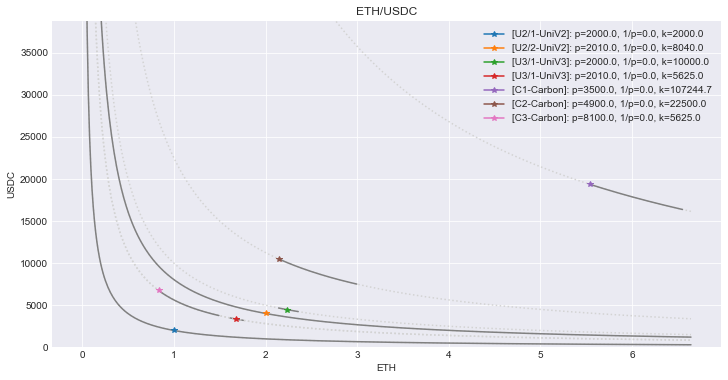

pair = USDC/ETH


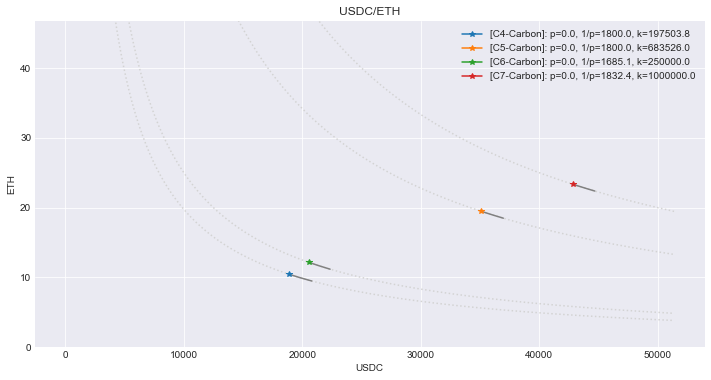

In [19]:
curves = curves_uni + curves_carbon
CC = CPCContainer(curves)
CC.plot(params=CC.Params())

## Serializing curves

The `CPCContainer` and `ConstantProductCurve` objects do not strictly have methods that would allow for serialization. However, they allow conversion from an to datatypes that are easily serialized. 

- on the `ConstantProductCurve` level there is `asdict()` and `from_dicts(.)`
- on the `CPCContainer` level there is also `asdf()` and `from_df(.)`, allowing conversion from and to pandas dataframes

Recommended serialization is either dict to json via the `json` library, or any of the serialization methods inherent in dataframes, notably also pickling (Excel formates are not recommended as they are slow and heavy).




In [20]:
curves = [
    CPC.from_univ2(x_tknb=1, y_tknq=2000, pair="ETH/USDC", fee=0.001, cid="1", descr="UniV2", params={"meh":1}),
    CPC.from_univ2(x_tknb=2, y_tknq=4020, pair="ETH/USDC", fee=0.001, cid="2", descr="UniV2"),
    CPC.from_univ2(x_tknb=1, y_tknq=1970, pair="ETH/USDC", fee=0.001, cid="3", descr="UniV2"),
]

In [21]:
c0 = curves[0]
assert c0.params.__class__.__name__ == "AttrDict"
assert c0.params == {'meh': 1}

In [22]:
CC = CPCContainer(curves)
assert raises(CPCContainer, [1,2,3])
assert len(CC.curves) == len(curves)
assert len(CC.asdicts()) == len(CC.curves)
assert CPCContainer.from_dicts(CC.asdicts()) == CC
ccjson = json.dumps(CC.asdicts())
assert CPCContainer.from_dicts(json.loads(ccjson)) == CC
CC

CPCContainer(curves=[ConstantProductCurve(k=2000, x=1, x_act=1, y_act=2000, pair='ETH/USDC', cid='1', fee=0.001, descr='UniV2', params={'meh': 1}), ConstantProductCurve(k=8040, x=2, x_act=2, y_act=4020, pair='ETH/USDC', cid='2', fee=0.001, descr='UniV2', params={}), ConstantProductCurve(k=1970, x=1, x_act=1, y_act=1970, pair='ETH/USDC', cid='3', fee=0.001, descr='UniV2', params={})])

In [23]:
df = CC.asdf()
assert len(df) == 3
assert tuple(df.reset_index().columns) == ('cid', 'k', 'x', 'x_act', 'y_act', 'pair', 'fee', 'descr', 'params')
assert tuple(df["k"]) == (2000, 8040, 1970)
assert CPCContainer.from_df(df) == CC
df

,k,x,x_act,y_act,pair,fee,descr,params
cid,,,,,,,,
1,2000,1,1,2000,ETH/USDC,0.001,UniV2,{'meh': 1}
2,8040,2,2,4020,ETH/USDC,0.001,UniV2,{}
3,1970,1,1,1970,ETH/USDC,0.001,UniV2,{}


## Saving curves [NOTEST]

Most serialization methods we use go via the a pandas DataFram object. To create a dataframe we use the `asdf()` method, and to instantiate curve container from a dataframe we use `CPCContainer.from_df(df)`.

In [24]:
N=5000
curves = [
    CPC.from_univ2(x_tknb=1, y_tknq=2000, pair="ETH/USDC", fee=0.001, cid=1, descr="UniV2"),
    CPC.from_univ2(x_tknb=2, y_tknq=4020, pair="ETH/USDC", fee=0.001, cid=2, descr="UniV2"),
    CPC.from_univ2(x_tknb=1, y_tknq=1970, pair="ETH/USDC", fee=0.001, cid=3, descr="UniV2"),
]
CC = CPCContainer(curves*N)
df = CC.asdf()
#CC

### Formats
#### json

Using `json.dumps(.)` the list of dicts returned by `asdicts()` can be converted to json, and then saved as a textfile. When loaded back, the text can be expanded into json using `json.loads(.)` and the new object can be instantiated using `CPCContainer.from_dicts(dicts)`.

In [25]:
start_time = time.time()
cc_json = json.dumps(CC.asdicts())
print("len", len(cc_json))
CC2 = CPCContainer.from_dicts(json.loads(cc_json))
assert CC == CC2
print(f"elapsed time: {time.time()-start_time:.2f}s")
#CC2

len 1860000
elapsed time: 0.36s


#### csv

`to_csv` converts a dataframe to a csv file; this file can also be zipped; this format is ideal for maximum interoperability as pretty much every software allows dealing with csvs; it is very fast, and the zipped files are much smaller than everything else

In [26]:
start_time = time.time()
df.to_csv(".curves.csv")
df_csv = pd.read_csv(".curves.csv")
assert CPCContainer.from_df(df_csv) == CC
print(f"elapsed time: {time.time()-start_time:.2f}s")
df_csv[:3]

elapsed time: 0.30s


,cid,k,x,x_act,y_act,pair,fee,descr,params
0,1,2000,1,1,2000,ETH/USDC,0.001,UniV2,{}
1,2,8040,2,2,4020,ETH/USDC,0.001,UniV2,{}
2,3,1970,1,1,1970,ETH/USDC,0.001,UniV2,{}


#### tsv

`to_csv` can be used with `sep="\t"` to create a tab separated file

In [27]:
start_time = time.time()
df.to_csv(".curves.tsv", sep="\t")
df_tsv = pd.read_csv(".curves.tsv", sep="\t")
assert CPCContainer.from_df(df_tsv) == CC
print(f"elapsed time: {time.time()-start_time:.2f}s")

elapsed time: 0.29s


#### compressed csv

`to_csv` can be used with `compression = "gzip"` to create a compressed file. This is by far the smallest output available, and takes little more time compared to uncompressed.

In [28]:
start_time = time.time()
df.to_csv(".curves.csv.gz", compression = "gzip")
df_csv = pd.read_csv(".curves.csv.gz")
assert CPCContainer.from_df(df_csv) == CC
print(f"elapsed time: {time.time()-start_time:.2f}s")

elapsed time: 0.30s


#### Excel

`to_excel` converts the dataframe to an xlsx file; older versions of pandas may allow to also save in the old xls format, but this is deprecated; note that Excel files can be rather big, and saving them is very slow, 10-15x(!) longer than csv.

In [29]:
start_time = time.time()
df.to_excel(".curves.xlsx")
df_xlsx = pd.read_excel(".curves.xlsx")
assert CPCContainer.from_df(df_xlsx) == CC
print(f"elapsed time: {time.time()-start_time:.2f}s")
df_xlsx[:3]

elapsed time: 2.78s


,cid,k,x,x_act,y_act,pair,fee,descr,params
0,1,2000,1,1,2000,ETH/USDC,0.001,UniV2,{}
1,2,8040,2,2,4020,ETH/USDC,0.001,UniV2,{}
2,3,1970,1,1,1970,ETH/USDC,0.001,UniV2,{}


#### pickle

`to_pickle` pickles the dataframe; this format is rather big, but it is the fastest to process, albeit not at a significant margin

In [30]:
start_time = time.time()
df.to_pickle(".curves.pkl")
df_pickle = pd.read_pickle(".curves.pkl")
assert CPCContainer.from_df(df_pickle) == CC
print(f"elapsed time: {time.time()-start_time:.2f}s")
df_pickle[:3]

elapsed time: 0.26s


,k,x,x_act,y_act,pair,fee,descr,params
cid,,,,,,,,
1,2000,1,1,2000,ETH/USDC,0.001,UniV2,{}
2,8040,2,2,4020,ETH/USDC,0.001,UniV2,{}
3,1970,1,1,1970,ETH/USDC,0.001,UniV2,{}


### Benchmarking

below a comparison of the different methods in terms of size and speed; the benchmark run used **300,000 curves**

    33000000  .curves.json      --  5.2s (without read/write)
    11100035  .curves.csv       --  3.4s
       37817  .curves.csv.gz    --  3.4s
    15602482  .curves.pkl       --  2.6s
    11100035  .curves.tsv       --  3.2s
     8031279  .curves.xlsx      -- 45.0s (!)
     
Below are the figures for the current run (timing figures inline above)

In [31]:
print(f"{len(df_xlsx)} curves")
print(f"                         {len(cc_json)}              .curves.json", )
!ls -l .curves*

15000 curves
                         1860000              .curves.json
-rw-r--r--  1 skl  staff  600042  9 Apr 23:34 .curves.csv
-rw-r--r--  1 skl  staff    2191  9 Apr 23:34 .curves.csv.gz
-rw-r--r--  1 skl  staff  856295  9 Apr 23:35 .curves.pkl
-rw-r--r--  1 skl  staff  600042  9 Apr 23:34 .curves.tsv
-rw-r--r--  1 skl  staff  454206  9 Apr 23:35 .curves.xlsx
